In [2]:
#!pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-2.3.1/es_core_news_sm-2.3.1.tar.gz

In [3]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import es_core_news_sm
import spacy
from spacy.matcher import Matcher

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### WEBSCRAPPING


Extracción de datos a partir de las reviews en TripAdvisor.

In [150]:
num_paginas = 25
num = 10

tabla = pd.DataFrame(columns=['Nota', 'Título', 'Review', 'Fecha'])

lista_notas = []
lista_titulos = []
lista_reviews = []
lista_fechas = []

for i in range(0, num_paginas):
  url = 'https://www.tripadvisor.es/Restaurant_Review-g659597-d6980022-' + 'or' + str(num) + '-Reviews-Trocadero_Sotogrande-San_Roque_Costa_de_la_Luz_Andalucia.html'

  pagina = requests.get(url).text
  soup = BeautifulSoup(pagina, 'lxml')

  for item in soup.find_all('div', class_='ui_column is-9'):

    bubble = item.select_one('span.ui_bubble_rating')['class'][1]
    lista_notas.append(re.findall('\d', bubble)[0])
    lista_titulos.append(item.find('div', class_='quote').text)
    lista_reviews.append(item.find('div', class_='entry').text)
    fecha = item.find('div', class_='prw_rup prw_reviews_stay_date_hsx').text
    lista_fechas.append(re.sub('\D', '', fecha))

  num = int(num) + 10
  i = i + 1

tabla['Nota'] = lista_notas
tabla['Título'] = lista_titulos
tabla['Review'] = lista_reviews
tabla['Fecha'] = lista_fechas

In [151]:
tabla.drop(tabla.loc[231:249].index, inplace=True)
tabla.drop(tabla.loc[0:2].index, inplace=True)
tabla.reset_index(inplace=True)

### ANÁLISIS Y VISUALIZACIÓN DE DATOS

La estructura de datos resultante presenta la siguiente forma:

In [152]:
tabla.head()

,index,Nota,Título,Review,Fecha
0,3,5,Imperdible,Si no esta en tu presupuesto una comida en est...,2019
1,4,4,Lujo de lugar,El lugar nos sigue pareciendo una maravilla pe...,2019
2,5,3,Mala calidad,"El grupo Trocadero tiene muchas virtudes , per...",2019
3,6,1,Decepcionado 100%,La noche comenzó mal ya que habiendo reservado...,2019
4,7,5,Beach Club espectacular,Me parece la mejor opción para disfrutar de un...,2019


In [153]:
# Retoques previos

tabla['Fecha'].replace('', '2014', inplace=True)

tabla.loc[209, 'Fecha'] = '2015'
tabla.loc[210, 'Fecha'] = '2015'

Primer vistazo al número de valoraciones por nota.

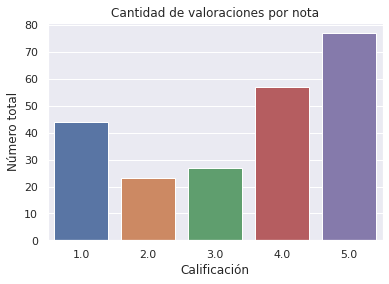

Nota media: 3.44


In [207]:
sns.countplot(tabla['Nota'], data=tabla)

plt.title('Cantidad de valoraciones por nota')
plt.xlabel('Calificación')
plt.ylabel('Número total')

plt.show()

media = tabla['Nota'].sum() / len(tabla)
print('Nota media:', media.round(2))

Tenemos muchas valoraciones con buenas notas de media lo que, a priori, parece buena señal.

---

Veamos ahora si ha habido una evolución en la media anual.

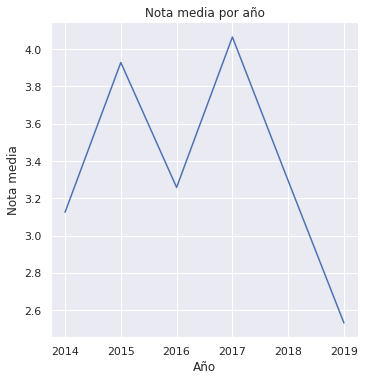

In [155]:
tabla['Nota'] = tabla['Nota'].astype('float')
nota_by_age = tabla.groupby(['Fecha'])['Nota'].mean()

sns.relplot(kind='line', data=nota_by_age)

plt.title('Nota media por año')
plt.xlabel('Año')
plt.ylabel('Nota media')

plt.show()

Parece que desde el 2017 hasta ahora han ido empeorando las valoraciones. Sobre todo 2019, siendo el primer año que tiene de media una nota mala (inferior a 3, que es una valoración intermedia) de 2.5

---

Para simplicarlo todo un poco más, convertimos las puntuaciones bajas como malas y las altas como buenas. Comprobamos la relación que existe por año entre éstas, descartando las medias.

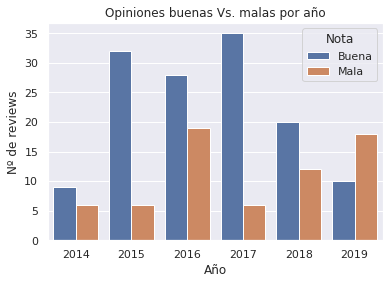

In [156]:
sin_medias = tabla.copy()

sin_medias['Nota'] = sin_medias['Nota'].map({1.0: 'Mala', 2.0: 'Mala', 3.0: 'Media', 4.0: 'Buena', 5.0: 'Buena'})
sin_medias = sin_medias[(sin_medias['Nota'] != 'Media')]

sns.set(style="darkgrid")
sns.countplot(sin_medias['Fecha'], hue=sin_medias['Nota'])

plt.title('Opiniones buenas Vs. malas por año')
plt.xlabel('Año')
plt.ylabel('Nº de reviews')

plt.show()

Volvemos a ver como 2019 ha sido el año más problemático. Es el único con más valoraciones malas que buenas.

### ANÁLISIS NLP



In [157]:
# Cargamos el modelo de la lengua española
# Añadimos algunos stop words que previamente nos percatamos que no incluye el modelo de spacy y otras palabras que no interesan

nlp = es_core_news_sm.load()
stop_words = ['beach', 'club', 'de', 'lo', 'que', 'restaurante', 'sin', 'sitio', 'sotogrande', 'y', 'ya']

for word in stop_words:
  nlp.Defaults.stop_words.add(word)

Vamos a analizar un poco tanto el título de la review como el cuerpo de esta.

---

Comenzaremos limpiando el texto del título de elementos innecesarios.

In [159]:
for i in range(0, len(tabla)):
  tabla['Título'] = tabla['Título'].apply(lambda x: x.lower())

  doc = nlp(tabla['Título'][i])
  texto = ''

  for token in doc:
    if not token.is_punct and not token.is_stop:
      #token.lemma_
      texto = texto + token.text + ' '
      tabla.loc[i, 'Título'] = texto

Ahora visualizamos en una nube de palabras cuáles son las más 
repetidas por año

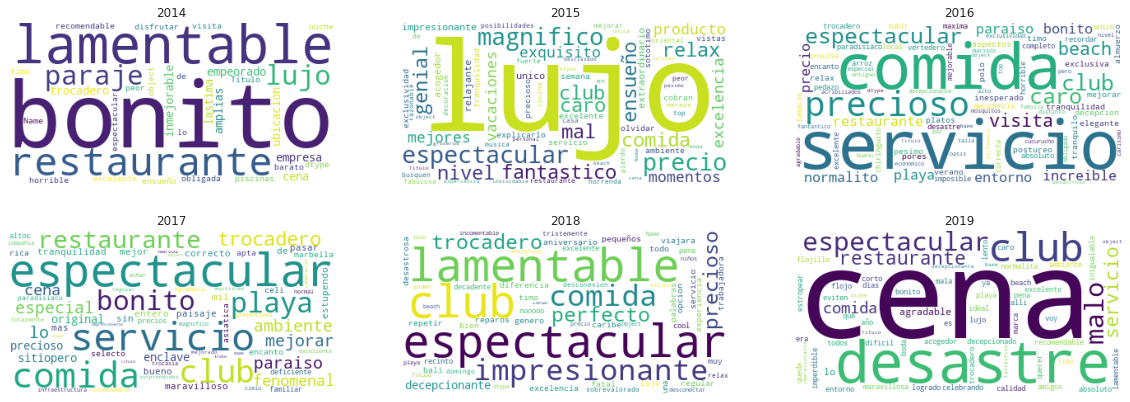

In [160]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',
                      max_font_size = 150)

lista_fechas = ['2014', '2015', '2016', '2017', '2018', '2019']

fig = plt.figure(1)
for i in range(0, 6):
  posicion = i + 1

  df = tabla[tabla['Fecha'] == lista_fechas[i]]
  fecha = lista_fechas[i]

  wordcloud.generate(str(df['Título']))
  plt.subplot(2, 3, posicion)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(fecha)

  fig.set_size_inches(w=20,h=7)

  i = i + 1

plt.show()


Aplicamos la misma limpieza de texto de antes pero esta vez con el cuerpo de la review.

In [161]:
for i in range(0, len(tabla)):
  tabla['Review'] = tabla['Review'].apply(lambda x: x.lower())

  doc = nlp(tabla['Review'][i])
  texto = ''

  for token in doc:
    if not token.is_punct and not token.is_stop:
      texto = texto + token.text + ' '
      texto = texto.replace('\n', '')
      tabla.loc[i, 'Review'] = texto

En la siguiente función buscamos por una palabra concreta en todas las reviews y vemos su adjetivo colindante y la nota media en las que incluye dicha palabra.

In [187]:
def buscaMatches(nlp, palabra, df):

  notas = []
  adjetivos = []
  matches = []

  matcher = Matcher(nlp.vocab)

  patron = [{'LOWER': palabra},
          {'POS': 'DET', 'OP': '?'},
          {'POS': 'ADJ'}]

  matcher.add('buscaMatches', None, patron)

  for i in range(0, len(df)):
    nota = df['Nota'][i]
    frase = df['Review'][i]

    doc = nlp(frase)

    if matcher:
      for match_id, start, end in matcher(doc):
        notas.append(nota)
        
        adjetivo = doc[start + 1]

        if adjetivo.pos_ == 'ADJ':
          adjetivos.append(adjetivo.text)


  dict_adj = {}

  for adj in adjetivos:
    contador = adjetivos.count(adj)
    dict_adj.update({adj: contador})

  try:
    print('Nota media: ', sum(notas) / len(notas))

    plt.figure(figsize=(20,8))

    fig = sns.barplot(list(dict_adj.keys()), list(dict_adj.values()))

    plt.title('Cantidad de veces que el adjetivo se ha hecho mención')
    plt.xlabel('Adjetivos')
    plt.ylabel('Nº de ocurrencias')
    fig.set_xticklabels(fig.get_xticklabels(), rotation=60)

    plt.show()

  except:
    print('No se ha encontrado ninguna coincidencia')


Podemos probar nosotros mismos buscando por ejemplo con 'servicio'.


servicio
Nota media:  3.0256410256410255


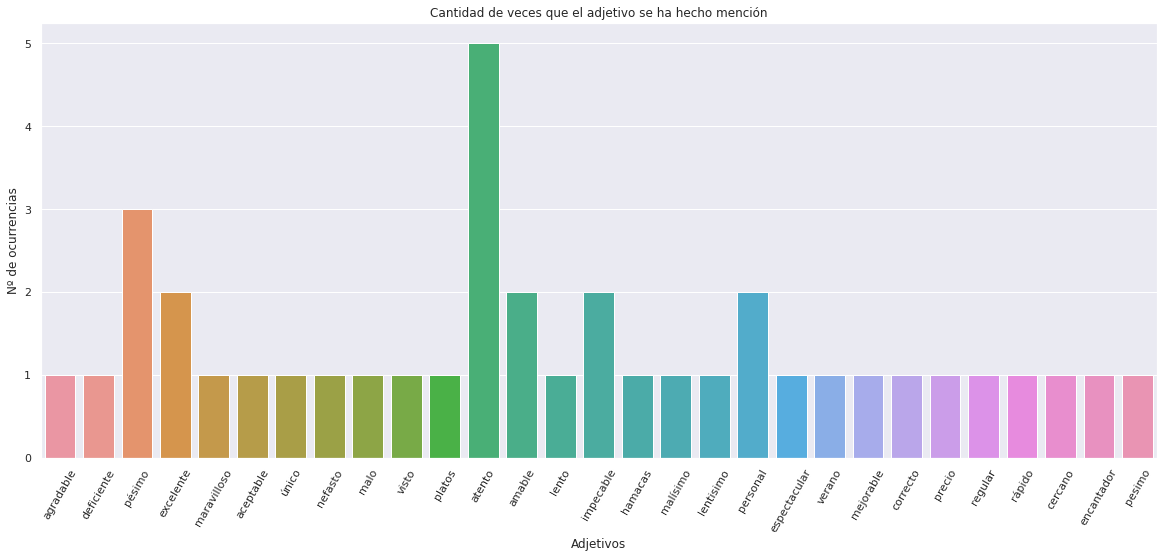

In [163]:
buscaMatches(nlp, 'servicio', tabla)

Vemos que la nota es un aprobado raspado, a pesar de tener como adjetivo más utilizado 'atento'.

---

Busquemos ahora por la comida.

Nota media:  3.7333333333333334


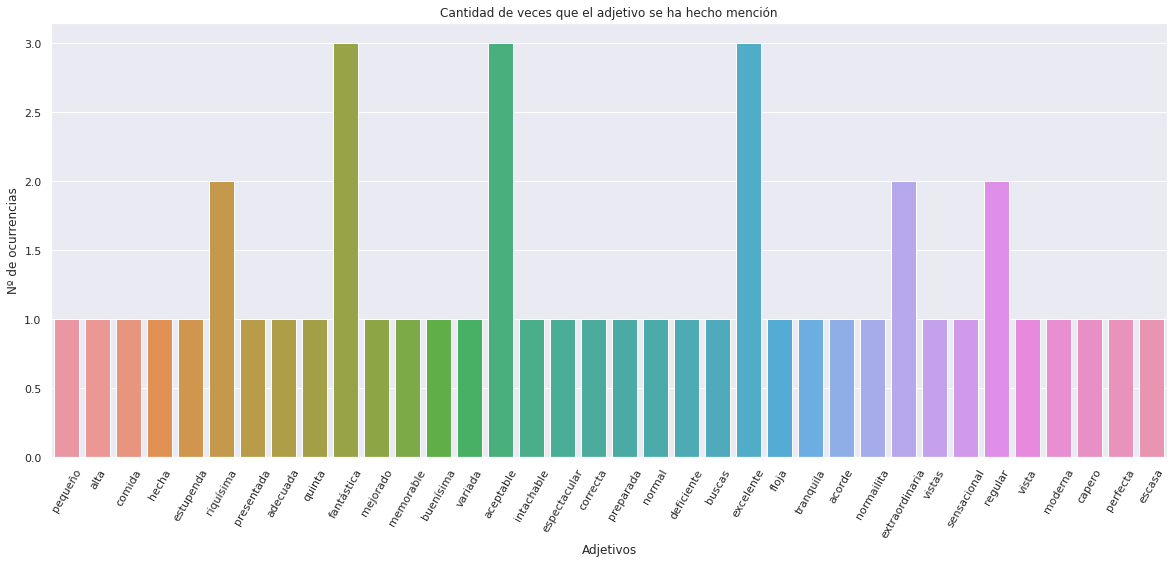

In [208]:
buscaMatches(nlp, 'comida', tabla)

En ese caso la media sube 0.7 puntos y llega casi a una puntuación de 4. Además vemos bastante frecuencia de adjetivos benévolos como fantástico o excelente.

---

Vamos a buscar por el servicio en 2019, puesto que, como vimos anteriormente, ha sido el año más problemático.

Nota media:  2.7142857142857144


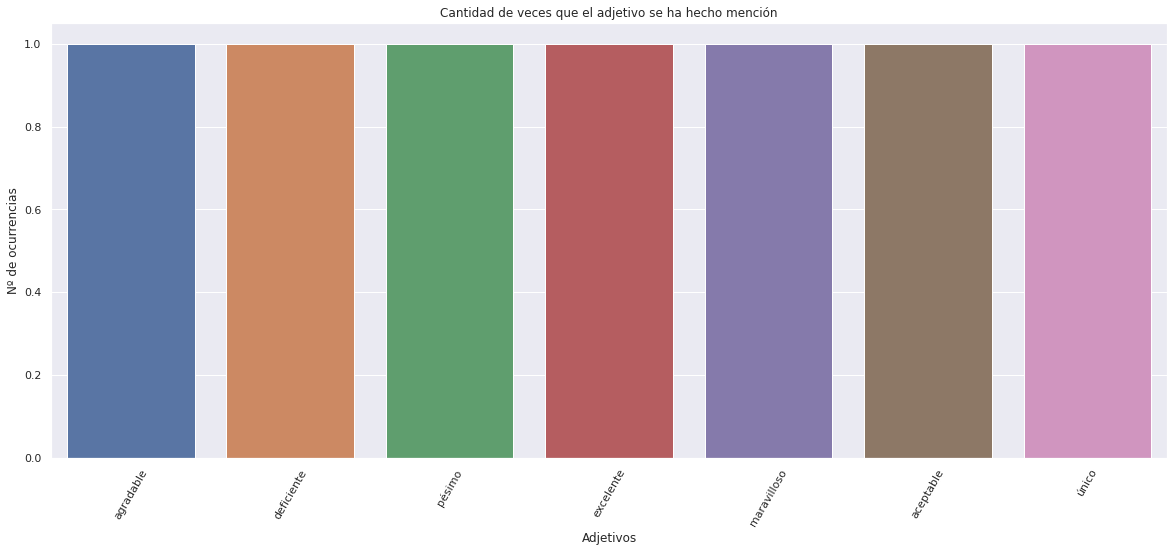

In [197]:
dos_19 = tabla.loc[tabla['Fecha'] == '2019']
buscaMatches(nlp, 'servicio', dos_19)

Vemos como la nota media ha bajado 0.3 puntos pero no ha encontrado muchos adjetivos para 'servicio'.

De la misma forma podemos buscar por algún año o palabra en concreto.


### CONCLUSIÓN

El estudio se podría extender tanto como quisiéramos pero el objetivo principal de este *notebook* es observar como se desenvuelve Spacy con la lengua española. Es evidente que este tipo de librerías tienen siempre más desarrollo en la lengua inglesa, además de ser un más simple.

Hemos podido hacer un estudio básico de un restaurante famoso de Sotogrande, analizar cuáles son las palabras más repetidas por año y filtrar textos por algún término en concreto y su adjetivo en las reviews de Tripadvisor.

Se podría hacer lo mismo con Google Maps, aunque hay que disponer de una cuenta de Google My Business, la cual sólo puede tener acceso el propietario de la empresa.